# Think Bayes

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from scipy.stats import poisson

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint

import thinkbayes2
import thinkplot

import pymc3 as pm
import theano.tensor as T

/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Fake data

In [2]:
n = 60
t1 = 30
t2 = n-t1
lam1 = 4
lam2 = 2

2

In [3]:
before = poisson(lam1).rvs(t1)

array([2, 7, 2, 2, 2, 4, 4, 7, 8, 3, 3, 4, 6, 5, 2, 2, 5, 5, 4, 5, 5, 3,
       9, 2, 5, 3, 6, 6, 5, 4])

In [4]:
after = poisson(lam2).rvs(t2)

array([2, 3, 1, 2, 1, 3, 3, 1, 4, 0, 1, 1, 1, 3, 3, 3, 2, 5, 3, 0, 2, 1,
       1, 4, 4, 4, 0, 0, 2, 0])

In [5]:
data = np.concatenate([before, after])

array([2, 7, 2, 2, 2, 4, 4, 7, 8, 3, 3, 4, 6, 5, 2, 2, 5, 5, 4, 5, 5, 3,
       9, 2, 5, 3, 6, 6, 5, 4, 2, 3, 1, 2, 1, 3, 3, 1, 4, 0, 1, 1, 1, 3,
       3, 3, 2, 5, 3, 0, 2, 1, 1, 4, 4, 4, 0, 0, 2, 0])

### Grid algorithm

In [29]:
from thinkbayes2 import EvalPoissonPmf

class Change(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: array of counts
        hypo: t, lam1, lam2
        """
        t, lam1, lam2 = hypo
        before_counts = data[:t]
        before_likelihood = np.product([EvalPoissonPmf(c, lam1) for c in before_counts])
        
        after_counts = data[t:]
        after_likelihood = np.product([EvalPoissonPmf(c, lam2) for c in after_counts])
        return before_likelihood * after_likelihood

In [22]:
import itertools

In [32]:
rate_prior = thinkbayes2.MakeExponentialPmf(lam=1/np.mean(data), n=10, high=2*np.mean(data))
t_prior = Pmf(range(len(data)))

prior = Change()
for vals in itertools.product(t_prior.Items(), rate_prior.Items(), rate_prior.Items()):
    prior.Incr(tuple([val for val, p in vals]), np.product([p for val, p in vals]))
    
print(len(prior))

posterior = prior.Copy();
posterior.Update(data)

6000


3.80894134630938e-53

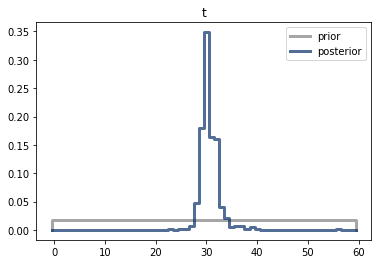

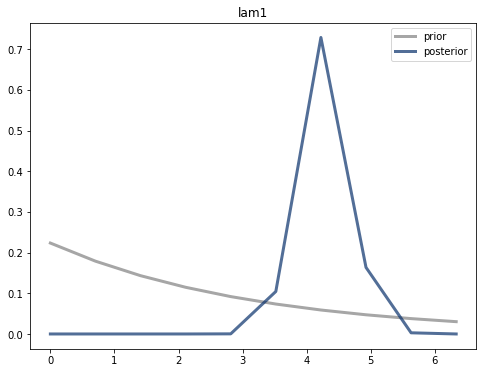

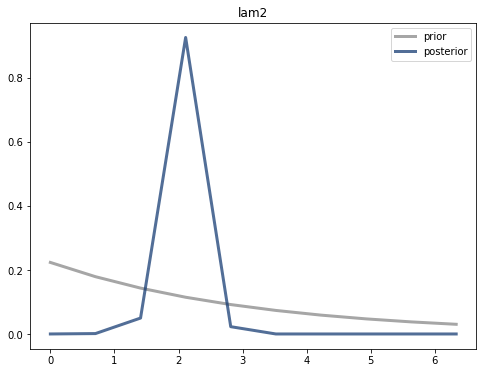

<Figure size 576x432 with 0 Axes>

In [33]:
thinkplot.Pmf(t_prior, label='prior', color='grey')
thinkplot.Pmf(posterior.Marginal(0), label='posterior')
thinkplot.Config(title='t')
thinkplot.Show();

thinkplot.Pdf(rate_prior, label='prior', color='grey')
thinkplot.Pdf(posterior.Marginal(1), label='posterior')
thinkplot.Config(title='lam1')
thinkplot.Show();

thinkplot.Pdf(rate_prior, label='prior', color='grey')
thinkplot.Pdf(posterior.Marginal(2), label='posterior')
thinkplot.Config(title='lam2')
thinkplot.Show();

### MCMC

To implement this model in PyMC, see Chapter 1 of [Bayesian Methods for Hackers](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC2.ipynb)
and this example from [Computational Statistics in Python](http://people.duke.edu/~ccc14/sta-663-2016/16C_PyMC3.html#Changepoint-detection)

In [43]:
%psource T.choose

In [42]:
%psource pm.Exponential

In [47]:
t = range(len(data))
with pm.Model() as model:
    cp = pm.DiscreteUniform('cp', lower=0, upper=len(data))
    lam1 = pm.Exponential('lam1', lam=1/np.mean(data))
    lam2 = pm.Exponential('lam2', lam=1/np.mean(data))
    
    lams = T.choose(t < cp, [[lam1], [lam2]], mode='wrap')
    counts = pm.Poisson('counts', mu=lams, observed=data)

In [56]:
## Check prior
with model:
    trace_prior = pm.sample_prior_predictive(10)

trace_prior['counts']

array([[ 4,  5,  2,  4,  3,  5,  2,  1,  2,  5,  4,  4,  6,  3,  7,  9,
         6,  8, 11,  5,  9,  9,  6,  8,  9,  6, 14,  8,  7, 19,  6,  9,
        10, 13,  6, 11,  9, 12,  7,  5,  4,  7,  8,  7, 11, 10,  8, 12,
        14,  9, 10,  8,  9,  7,  6, 12,  8,  7,  9,  5],
       [ 4,  4,  8,  5,  1,  5,  3,  8,  5,  9,  9,  5,  8,  6,  5, 11,
         3, 12,  8,  3,  6,  5,  5,  5,  7, 11,  8,  6, 10,  6, 10, 11,
         9,  7, 10,  7, 10,  3,  4,  5,  5,  4, 11,  5,  8, 13,  3,  9,
         6,  6,  9,  5,  6,  6,  7,  5,  9, 12,  6,  8],
       [ 4,  0,  1,  1,  1,  1,  1,  1,  0,  2,  3,  1,  0,  1,  2,  1,
         2,  2,  0,  0,  1,  1,  3,  2,  1,  1,  2,  0,  3,  2,  1,  0,
         2,  1,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1,  1,
         2,  1,  1,  1,  2,  3,  0,  1,  1,  1,  1,  1],
       [ 2,  4,  4,  4,  1,  3,  4,  5,  3,  5,  7,  4,  3,  3,  7,  6,
         2,  8,  5,  6,  3,  2,  3,  2,  1,  2,  2,  1,  1,  4,  1,  3,
         3,  2,  4,  4,  1,  4,  3,  

### Real data

Some real data, based on [this analysis from the Baltimore Sun](http://www.baltimoresun.com/news/maryland/crime/bs-md-ci-violence-stats-20181018-story.html)

In [ ]:
# !wget https://raw.githubusercontent.com/baltimore-sun-data/2018-shootings-analysis/master/BPD_Part_1_Victim_Based_Crime_Data.csv

In [ ]:
df = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv', parse_dates=[0])
df.head()

In [ ]:
df.shape

In [ ]:
shootings = df[df.Description.isin(['HOMICIDE', 'SHOOTING']) & (df.Weapon == 'FIREARM')]
shootings.shape

In [ ]:
grouped = shootings.groupby('CrimeDate')

In [ ]:
counts = grouped['Total Incidents'].sum()
counts.head()

In [ ]:
index = pd.date_range(counts.index[0], counts.index[-1])

In [ ]:
counts = counts.reindex(index, fill_value=0)
counts.head()

In [ ]:
counts.plot()
thinkplot.decorate(xlabel='Date',
                   ylabel='Number of shootings')